# <h1><center>TP3 - Visión por computadora - CEIA</center></h1>

In [1]:
# Importaciones
%matplotlib inline

import numpy as np
import cv2 as cv
import os
import matplotlib.pyplot as plt
import math

<center>

<img src="./resources/portada.jpeg" width="600" alt="Figura 1: A computer vision expert, doing template matching of a dragon, in a scene of dragons fighting with a Game of Thrones setting - Generada con Microsoft Image Creator">

<small><em>Figura 1: A computer vision expert, doing template matching of a dragon, in a scene of dragons fighting with a Game of Thrones setting - Generada con Microsoft Image Creator</em></small>

</center>

<center>
<em>Datos del proyecto:</em>

| Subtitulo       | TP3 - Visión por computadora - FIUBA                                                                                                   |
| --------------- | -------------------------------------------------------------------------------------------------------------------------------------- |
| **Descrpción**  | Template matching                                                                                                                      |
| **Integrantes** | Bruno Masoller (brunomaso1@gmail.com)                                                                                                |

</center>

## Consinga

![Consinga](.\resources\Consigna.PNG)


## Parte 1

> Obtener una detección del logo en cada imagen sin falsos positivos

<em>
Para resolver este problema, se plantea utilizar el algoritmo de template matching, pero previamente haber aplicado un algoritmo de detección de bordes. O sea, el algoritmo es el siguiente:

1. Transformar el template matching a una imagen de bordes utilizando un algoritmo acorde (por ejemplo, Canny).
2. Transformar la imagen objetivo utilizando el mismo algoritmo.
3. Realizar el template matching.
</em>

*Exploración de las imágenes:*

*Primeramente exploramos las imágenes para investigar posibles problemas.*

In [2]:
# Funcion auxiliar para cargar imágenes de un directorio
def cargar_imagenes(carpeta):
    imagenes_rgb = []
    for nombre_archivo in os.listdir(carpeta):
        ruta_archivo = os.path.join(carpeta, nombre_archivo)
        if os.path.isfile(ruta_archivo) and ruta_archivo.endswith(('.png', '.jpg', '.jpeg')):
            imagen = cv.imread(ruta_archivo)
            imagen_rgb = cv.cvtColor(imagen, cv.COLOR_BGR2RGB)
            imagenes_rgb.append(imagen_rgb)
    return imagenes_rgb

In [3]:
def mostrar_imagenes(imagenes_rgb, title=None, cant_col=3, figsize=(12, 4)):
    num_imagenes = len(imagenes_rgb)

    # Calculo la cantidad de filas según las columnas deseadas
    filas = (num_imagenes // cant_col) + \
        (1 if num_imagenes % cant_col != 0 else 0)

    fig, axes = plt.subplots(filas, cant_col, figsize=(
        figsize[0], figsize[1] * filas))
    fig.suptitle(title)

    # Eliminar ejes de subplots que no se usan
    if filas * cant_col == num_imagenes:
        for i in range(filas * cant_col):
            fila = i // cant_col
            columna = i % cant_col
            if i < num_imagenes:
                axes[fila, columna].imshow(imagenes_rgb[i])
                axes[fila, columna].axis('off')
            else:
                axes[fila, columna].axis('off')
    else:
        for i in range((filas - 1) * cant_col):
            fila = i // cant_col
            columna = i % cant_col
            if i < num_imagenes:
                axes[fila, columna].imshow(imagenes_rgb[i])
                axes[fila, columna].axis('off')
            else:
                axes[fila, columna].axis('off')

        columnas_usadas = num_imagenes % cant_col
        columnas_vacias = cant_col - columnas_usadas
        posicion_centrada = columnas_vacias // 2

        for col in range(cant_col):
            if col < posicion_centrada or col >= posicion_centrada + columnas_usadas:
                axes[filas - 1, col].axis('off')
            else:
                imagen_index = (filas - 1) * cant_col + \
                    (col - posicion_centrada)
                axes[filas - 1, col].imshow(imagenes_rgb[imagen_index])
                axes[filas - 1, col].axis('off')

    plt.tight_layout()
    plt.show()

*Mostramos todas las imágenes a procesar:*

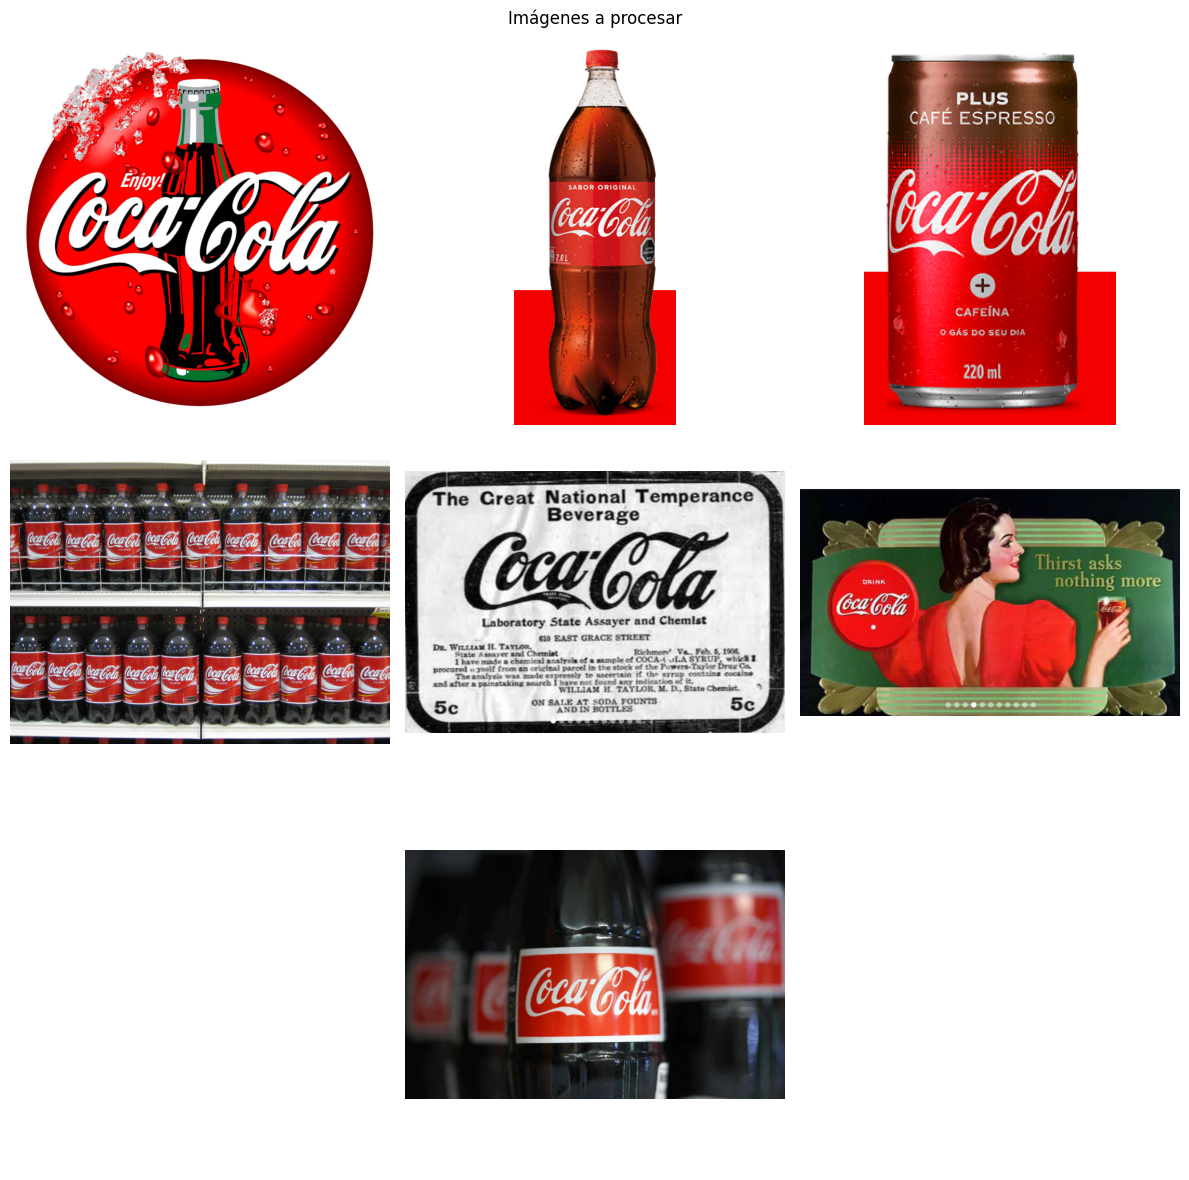

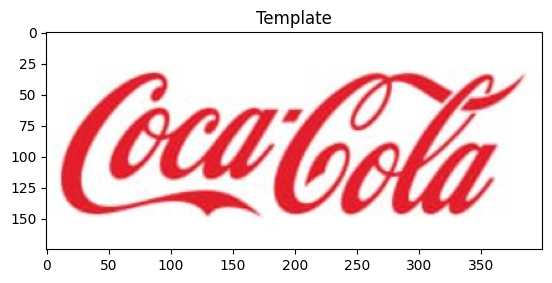

In [4]:
imagenes_rgb = cargar_imagenes('./resources/images/')
template_rgb = cv.cvtColor(cv.imread('./resources/template/pattern.png'), cv.COLOR_BGR2RGB) 
mostrar_imagenes(imagenes_rgb, title='Imágenes a procesar')

plt.figure()
plt.title('Template')
plt.imshow(template_rgb)
plt.show()

*Inicialmente podemos ver que difieren los tamaños entre el template y las imágenes, por lo que al algoritmo se propone agregarle variaciones de tamaño de lás imágenes y quedarse con la brinda mejor resultado de todas las comparaciones de tamaño.*

*Como análisis explotarorio, chequeamos que las imágenes no sean más chicas que el template:*

In [5]:
print(f'Tamaño del template: {template_rgb.shape}')
for img in imagenes_rgb:
    print(f'Tamaño de imagen: {img.shape}')

Tamaño del template: (175, 400, 3)
Tamaño de imagen: (1389, 1389, 3)
Tamaño de imagen: (500, 207, 3)
Tamaño de imagen: (363, 233, 3)
Tamaño de imagen: (598, 799, 3)
Tamaño de imagen: (493, 715, 3)
Tamaño de imagen: (429, 715, 3)
Tamaño de imagen: (450, 687, 3)


*Efectivamente, tenemos imágenes más chicas que el template. Esto genera un error en el método, por lo que para subsanar este problema, reducimos el tamaño del template:*

In [6]:
template_rgb = cv.resize(template_rgb, None, fx=0.5, fy=0.5)

In [7]:
from typing import List, Tuple

# TODO: Poner descipción + cambiar imports
def compute_all_img_sizes(imagen_rgb: np.ndarray, canny_thresshold: Tuple = (50, 200), linspace: Tuple = (0.05, 1.0, 50)) -> List:
    canny_th_low, canny_th_high = canny_thresshold
    linspace_low, linspace_high, linspace_step = linspace

    img_gray = cv.cvtColor(imagen_rgb, cv.COLOR_RGB2GRAY)

    img_edges_list = []
    for scale in np.linspace(linspace_low, linspace_high, linspace_step)[::-1]:
        img_edges_resized = cv.resize(img_gray, None, fx=scale, fy=scale)
        img_edges = cv.Canny(img_edges_resized, canny_th_low, canny_th_high, L2gradient=True)
        img_edges_list.append((img_edges, scale))

    return img_edges_list

*Realizamos la función que detecta solamente una imagen mediante el siguiente algoritmo:*

In [8]:
# TODO: Documentar
def detect_one_object(img_rgb: np.ndarray, template_rgb: np.ndarray, linspace: Tuple = (0.05, 2, 100), canny_thresshold: Tuple = (50, 200), method=cv.TM_CCORR_NORMED, debug=True, show_best_result=True) -> np.ndarray:
    # Primeramente calculo los bordes del template
    canny_low, canny_high = canny_thresshold
    template_edge = cv.Canny(cv.cvtColor(template_rgb, cv.COLOR_BGR2GRAY), canny_low, canny_high, L2gradient=True)
    
    # Calculo todos los tamaños de las imágenes
    img_edges_list = compute_all_img_sizes(img_rgb, canny_thresshold, linspace)
    
    h, w = template_edge.shape
    mejor_resultado = None
    
    if debug: print(f'Cantidad de imagenes a procesar: {len(img_edges_list)}')
    
    # Itero sobre las imágenes y le paso el template.
    for i, (img_edges, scale) in enumerate(img_edges_list):
        img_h, img_w = img_edges.shape
        
        # Si las imagenes que vienen, son menor que el template, no tiene sentido.
        if img_h < h or img_w < w:
            if debug: print(f'img_h, img_w : {(img_h, img_w)} | h, w: {(h, w)}')
            break
        
        result = cv.matchTemplate(img_edges, template_edge, method)
        (_, max_val, _, max_loc) = cv.minMaxLoc(result)

        mejor_resultado = (max_val, max_loc, i) if (mejor_resultado is None) or (mejor_resultado[0] < max_val) else mejor_resultado

        if debug: print(f'img_edges: {i} | img_edges: {img_edges.shape} | img_edge.scale: {scale:.2f} | resultado_actual: {(max_val, max_loc, i)} | mejor_resultado: {mejor_resultado}')
    
    max_val, max_loc, i = mejor_resultado
    escala = img_edges_list[i][1]

    # Tengo que dividir por la escala
    top_left = (int(max_loc[0]/escala), int((max_loc[1]/escala)))
    bottom_right = (int((max_loc[0] + w) /escala), int((max_loc[1] + h) / escala))
    
    cv.rectangle(img_rgb, top_left, bottom_right, (0, 150, 0), 4)
    cv.putText(img_rgb, f'V={max_val:.2f}', (top_left[0] - 2, top_left[1] - 5), cv.FONT_HERSHEY_SIMPLEX, 1 / escala, (0, 150, 0),  int(2 / escala))
    
    if debug or show_best_result: 
        best_image_edge = img_edges_list[i][0]
        best_scale = img_edges_list[i][1]
        print(f'Mejor resultado: {mejor_resultado} | Escala: {best_scale:.2f} | best_image_edge: {best_image_edge.shape}')
        
    return img_rgb

Mejor resultado: (0.2273535132408142, (13, 70), 95) | Escala: 0.17 | best_image_edge: (235, 235)
Mejor resultado: (0.48339951038360596, (32, 226), 62) | Escala: 1.15 | best_image_edge: (576, 239)
Mejor resultado: (0.23733019828796387, (4, 96), 71) | Escala: 0.88 | best_image_edge: (321, 206)
Mejor resultado: (0.29896241426467896, (294, 871), 32) | Escala: 2.05 | best_image_edge: (1224, 1635)
Mejor resultado: (0.2790234088897705, (38, 25), 88) | Escala: 0.38 | best_image_edge: (186, 270)
Mejor resultado: (0.36124885082244873, (76, 231), 58) | Escala: 1.27 | best_image_edge: (546, 909)
Mejor resultado: (0.27879267930984497, (132, 128), 78) | Escala: 0.68 | best_image_edge: (304, 464)


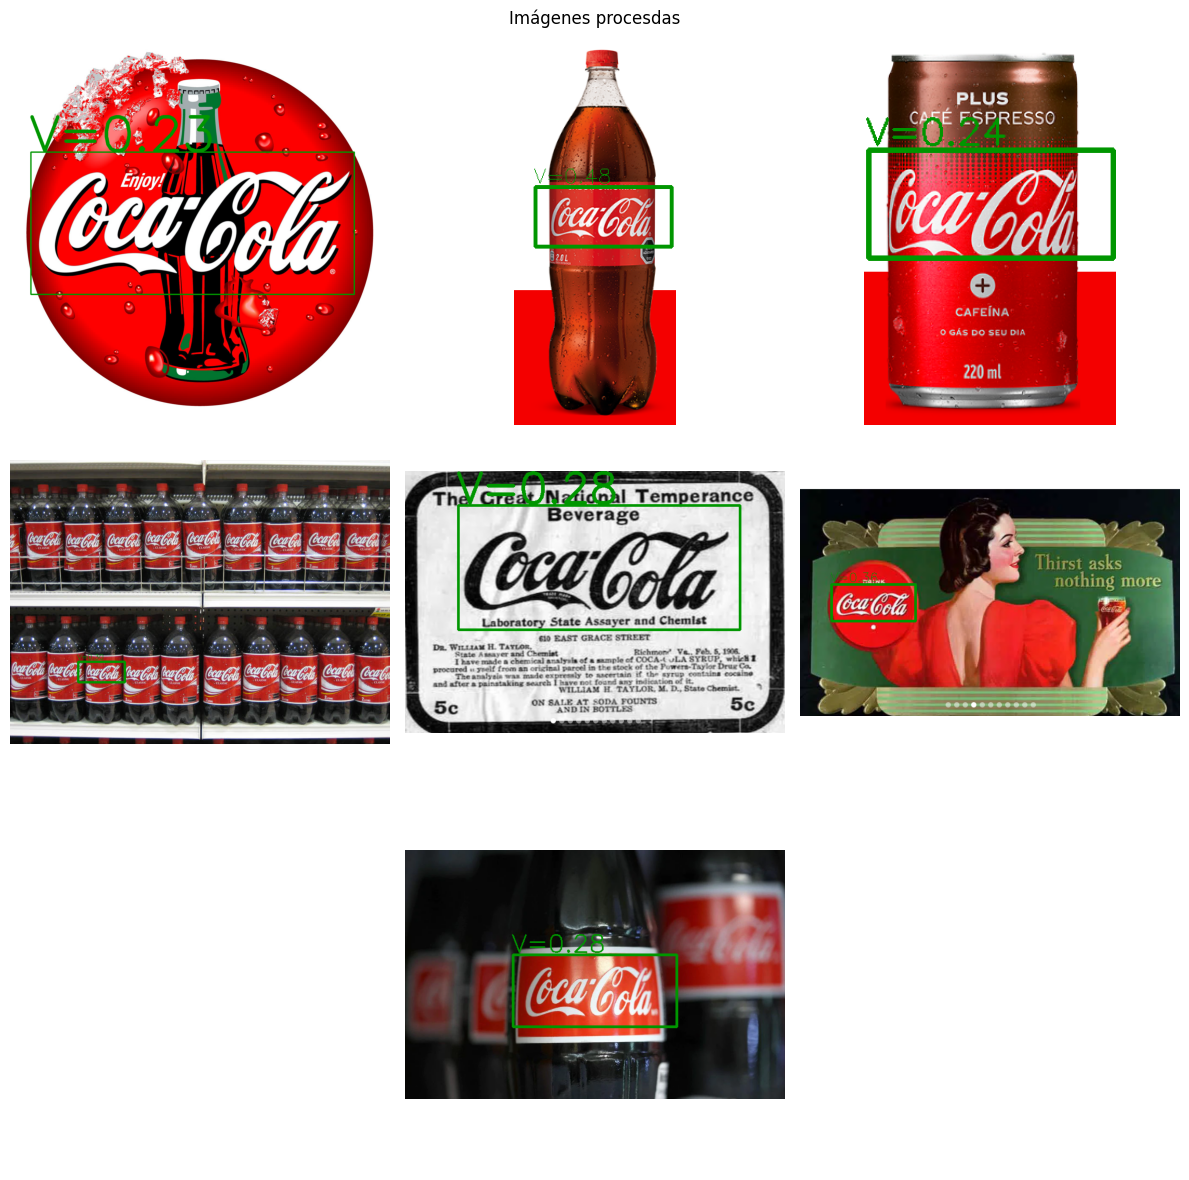

In [9]:
mostrar_imagenes([detect_one_object(img.copy(), template_rgb, (0.05, 3, 100), debug=False) for img in imagenes_rgb], title='Imágenes procesdas')

## Parte 2

> Plantear y validadr un algoritmo para múltiples detecciones en la imagen "coca_multi.png" con el mismo template del item 1

*Como investigación, primeramente vamos a graficar los valores de los máximos y sus escalas para cada imagen:*

*Funcion axiliar para mostrar los gráficos*

In [10]:
def mostrar_plots(datos, title=None, cant_col=3, figsize=(12, 4)):
    num_items = len(datos)

    # Calculo la cantidad de filas según las columnas deseadas
    filas = (num_items // cant_col) + (1 if num_items % cant_col != 0 else 0)

    fig, axes = plt.subplots(filas, cant_col, figsize=(figsize[0], figsize[1] * filas))
    fig.suptitle(title)

    if filas * cant_col == num_items:
        for i in range(filas * cant_col):
            fila = i // cant_col
            columna = i % cant_col
            if i < num_items:
                x_values = [scale for _, scale in datos[i]]
                y_values = [max_val for max_val, _ in datos[i]]
                axes[fila, columna].plot(x_values, y_values)
    else:
        for i in range((filas - 1) * cant_col):
            fila = i // cant_col
            columna = i % cant_col
            if i < num_items:
                x_values = [scale for _, scale in datos[i]]
                y_values = [max_val for max_val, _ in datos[i]]
                axes[fila, columna].plot(x_values, y_values)

        columnas_usadas = num_items % cant_col
        columnas_vacias = cant_col - columnas_usadas
        posicion_centrada = columnas_vacias // 2

        for col in range(cant_col):
            if col < posicion_centrada or col >= posicion_centrada + columnas_usadas:
                axes[filas - 1, col].axis('off')
            else:
                datos_index = (filas - 1) * cant_col + (col - posicion_centrada)
                x_values = [scale for _, scale in datos[datos_index]]
                y_values = [max_val for max_val, _ in datos[datos_index]]
                axes[filas - 1, col].plot(x_values, y_values)         

    plt.tight_layout()
    plt.show()

*Función auxiliar para obtener los resultados de cada pasada del template por una escala diferente:*

In [11]:
# TODO: Documentar
def detect_results(img_rgb: np.ndarray, template_rgb: np.ndarray, linspace: Tuple = (0.05, 2, 100), canny_thresshold: Tuple = (50, 200), method=cv.TM_CCORR_NORMED, threshold: float = 0.30, debug=True, show_best_result=True) -> np.ndarray:
    canny_low, canny_high = canny_thresshold
    template_edge = cv.Canny(cv.cvtColor(template_rgb, cv.COLOR_BGR2GRAY), canny_low, canny_high, L2gradient=True)
    img_edges_list = compute_all_img_sizes(img_rgb, canny_thresshold, linspace)
    
    h, w = template_edge.shape
    
    results = []
    for img_edges, scale in img_edges_list:
        img_h, img_w = img_edges.shape
        
        if img_h < h or img_w < w:
            break
        
        result = cv.matchTemplate(img_edges, template_edge, method)
        (_, max_val, _, _) = cv.minMaxLoc(result)
        
        results.append((max_val, scale))
        
    return results

*Mostramos los gráficos para todas las imágenes:*

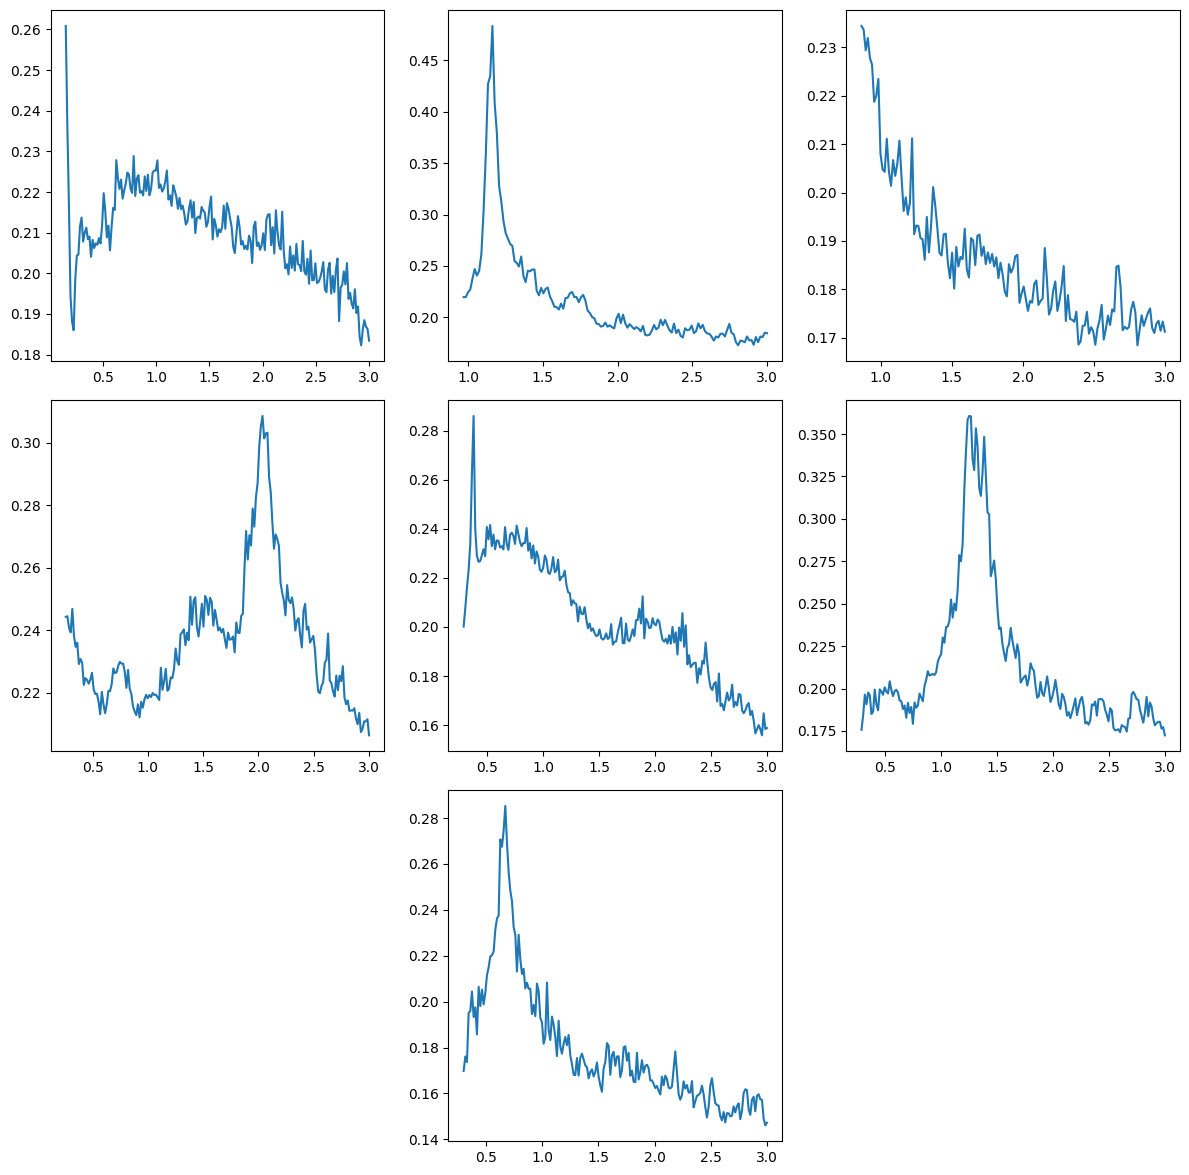

In [12]:
mostrar_plots([detect_results(img.copy(), template_rgb, (0.05, 3, 200)) for img in imagenes_rgb])

*El algoritmo hace lo mismo que el de detección de un objeto, solamente que en vez de quedarse con el máximo, se queda con los casos mayores a un umbral. Luego se aplica non maxial supression para eliminar los boxes excedentes.*

In [13]:
# TODO: Documentar
def detect_multiple_objects(img_rgb: np.ndarray, template_rgb: np.ndarray, linspace: Tuple = (0.05, 2, 100), canny_thresshold: Tuple = (50, 200), method=cv.TM_CCORR_NORMED, threshold: float = 0.25, nms_threshold: float = 100, debug=True, show_best_result=True) -> np.ndarray:
    canny_low, canny_high = canny_thresshold
    template_edge = cv.Canny(cv.cvtColor(template_rgb, cv.COLOR_BGR2GRAY), canny_low, canny_high, L2gradient=True)
    img_edges_list = compute_all_img_sizes(img_rgb, canny_thresshold, linspace)
    
    h, w = template_edge.shape    
    if debug: print(f'Cantidad de imagenes a procesar: {len(img_edges_list)}')
    
    mejor_resultado = None    
    for img_edges, scale in img_edges_list:
        img_h, img_w = img_edges.shape
        
        if img_h < h or img_w < w:
            if debug: print(f'img_h, img_w : {(img_h, img_w)} | h, w: {(h, w)}')
            break
        
        result = cv.matchTemplate(img_edges, template_edge, method)
        # Obtengo los resultados mayor al umbral.
        result_threshold = np.nonzero(result >= threshold)
        
        # Obtengo todas las cajas dado este result_threshold
        bboxes = [[x, y, x+w, y+h, result[y][x]] for (y,x) in zip(*result_threshold)]
        
        # Sigo con la misma política de quedarme con el mejor resultado según la cantidad de matches
        mejor_resultado = (bboxes, scale) if (mejor_resultado is None) or (len(mejor_resultado[0]) < len(bboxes)) else mejor_resultado
        if debug: print(f'img_edges: {img_edges.shape} | img_edge.scale: {scale:.2f} | resultado_actual: {len(bboxes)} | mejor_resultado: {(len(mejor_resultado[0]), mejor_resultado[1])} | resutls.len: {len(result_threshold[0])}')
    
    # Aplico NMS
    try:
        best_bboxes, best_scale = mejor_resultado
        best_bboxes = np.array(best_bboxes)
        scores = best_bboxes[:, 4]
        boxes = best_bboxes[:, :4]
        best_boxes_index = cv.dnn.NMSBoxes(boxes, scores, score_threshold=threshold, nms_threshold=nms_threshold)
        best_boxes = best_bboxes[best_boxes_index]

        for box in best_boxes:
            x1, y1, x2, y2, confidence = box
            top_left = (int(x1/best_scale), int(y1/best_scale))
            bottom_right = (int(x2/best_scale), int(y2/best_scale))
            cv.rectangle(img_rgb, top_left, bottom_right, (0, 150, 0), 4)
            cv.putText(img_rgb, f'V={confidence:.2f}', (top_left[0] - 2, top_left[1] - 5), cv.FONT_HERSHEY_SIMPLEX, 1 / best_scale, (0, 150, 0),  int(2 / best_scale))    
        
        if debug or show_best_result: 
            print(f'Mejor resultado: {len(best_bboxes)} | Escala: {best_scale:.2f}')
    except:
        print('Explotó (best_bboxes está vacio). Probá agregar mas iteraciones o cambiar el threshold')
        
    return img_rgb

*Aplicamos el algoritmo y mostramos las imágenes:*

In [14]:
mostrar_imagenes([detect_multiple_objects(img.copy(), template_rgb, (0.15, 2.1, 200), threshold=0.23, nms_threshold=0.2, debug=False) for img in imagenes_rgb])

## Parte 3

> Generalizar el algoritmo del item 2 para todas las imágenes

*Si bien el algoritmo del paso anteiror, también funciona para todas las imágenes, en este paso se generaliza para todas las imágenes independientemente del threshold. Lo que se hace es fijarse en un entorno del punto máximo. Luego el resto es igual.*

In [33]:
# TODO: Documentar
def super_detector(img_rgb: np.ndarray, template_rgb: np.ndarray, linspace: Tuple = (0.05, 2, 100), canny_thresshold: Tuple = (50, 200), method=cv.TM_CCORR_NORMED, nms_threshold: float = 100, debug=True, show_best_result=True) -> np.ndarray:
    canny_low, canny_high = canny_thresshold
    template_edge = cv.Canny(cv.cvtColor(
        template_rgb, cv.COLOR_BGR2GRAY), canny_low, canny_high, L2gradient=True)
    img_edges_list = compute_all_img_sizes(img_rgb, canny_thresshold, linspace)

    h, w = template_edge.shape
    if debug:
        print(f'Cantidad de imagenes a procesar: {len(img_edges_list)}')

    mejor_resultado = None
    for i, (img_edges, scale) in enumerate(img_edges_list):
        img_h, img_w = img_edges.shape

        if img_h < h or img_w < w:
            if debug:
                print(f'img_h, img_w : {(img_h, img_w)} | h, w: {(h, w)}')
            break

        result = cv.matchTemplate(img_edges, template_edge, method)
        (_, max_val, _, max_loc) = cv.minMaxLoc(result)
        threshold = max_val - 0.05

        # Obtengo los resultados mayor al umbral.
        result_threshold = np.nonzero(result >= threshold)

        # Obtengo todas las cajas dado este result_threshold
        bboxes = [[x, y, x+w, y+h, result[y][x]]
                  for (y, x) in zip(*result_threshold)]

        # Ahora me quedo el mejor resultado según el máximo.
        mejor_resultado = (max_val, max_loc, scale, bboxes, threshold, i) if (
            mejor_resultado == None) or (mejor_resultado[0] < max_val) else mejor_resultado
        if debug:
            print(f'iteracion: {i} | mejor_iteracion: {mejor_resultado[5]} | mejor_resultado: {(round(mejor_resultado[0], 4), mejor_resultado[1], round(mejor_resultado[2], 4), len(
                mejor_resultado[3]), round(mejor_resultado[4], 4))} | actual: {(round(max_val, 4), max_loc, round(scale, 4), len(bboxes), round(threshold, 4))}')

    # Aplica NMS
    max_val, max_loc, best_scale, best_bboxes, threshold, _ = mejor_resultado
    best_bboxes = np.array(best_bboxes)
    scores = best_bboxes[:, 4]
    boxes = best_bboxes[:, :4]
    best_boxes_index = cv.dnn.NMSBoxes(
        boxes, scores, score_threshold=threshold, nms_threshold=nms_threshold)
    boxes_filtered = best_bboxes[best_boxes_index]

    for box in boxes_filtered:
        x1, y1, x2, y2, confidence = box
        top_left = (int(x1/best_scale), int(y1/best_scale))
        bottom_right = (int(x2/best_scale), int(y2/best_scale))
        cv.rectangle(img_rgb, top_left, bottom_right, (0, 150, 0), 4)
        cv.putText(img_rgb, f'V={confidence:.2f}', (top_left[0] - 2, top_left[1] - 5),
                   cv.FONT_HERSHEY_SIMPLEX, 1 / best_scale, (0, 150, 0),  int(2 / best_scale))

    if debug or show_best_result:
        print(f'Mejor resultado: {max_val:.2f} | Escala: {
            best_scale:.2f} | objects_detected: {len(boxes_filtered)}')

    return img_rgb

Mejor resultado: 0.30 | Escala: 0.16 | objects_detected: 1
Mejor resultado: 0.47 | Escala: 1.15 | objects_detected: 1
Mejor resultado: 0.24 | Escala: 0.88 | objects_detected: 1
Mejor resultado: 0.31 | Escala: 2.02 | objects_detected: 13
Mejor resultado: 0.29 | Escala: 0.38 | objects_detected: 1
Mejor resultado: 0.37 | Escala: 1.24 | objects_detected: 1
Mejor resultado: 0.29 | Escala: 0.67 | objects_detected: 1


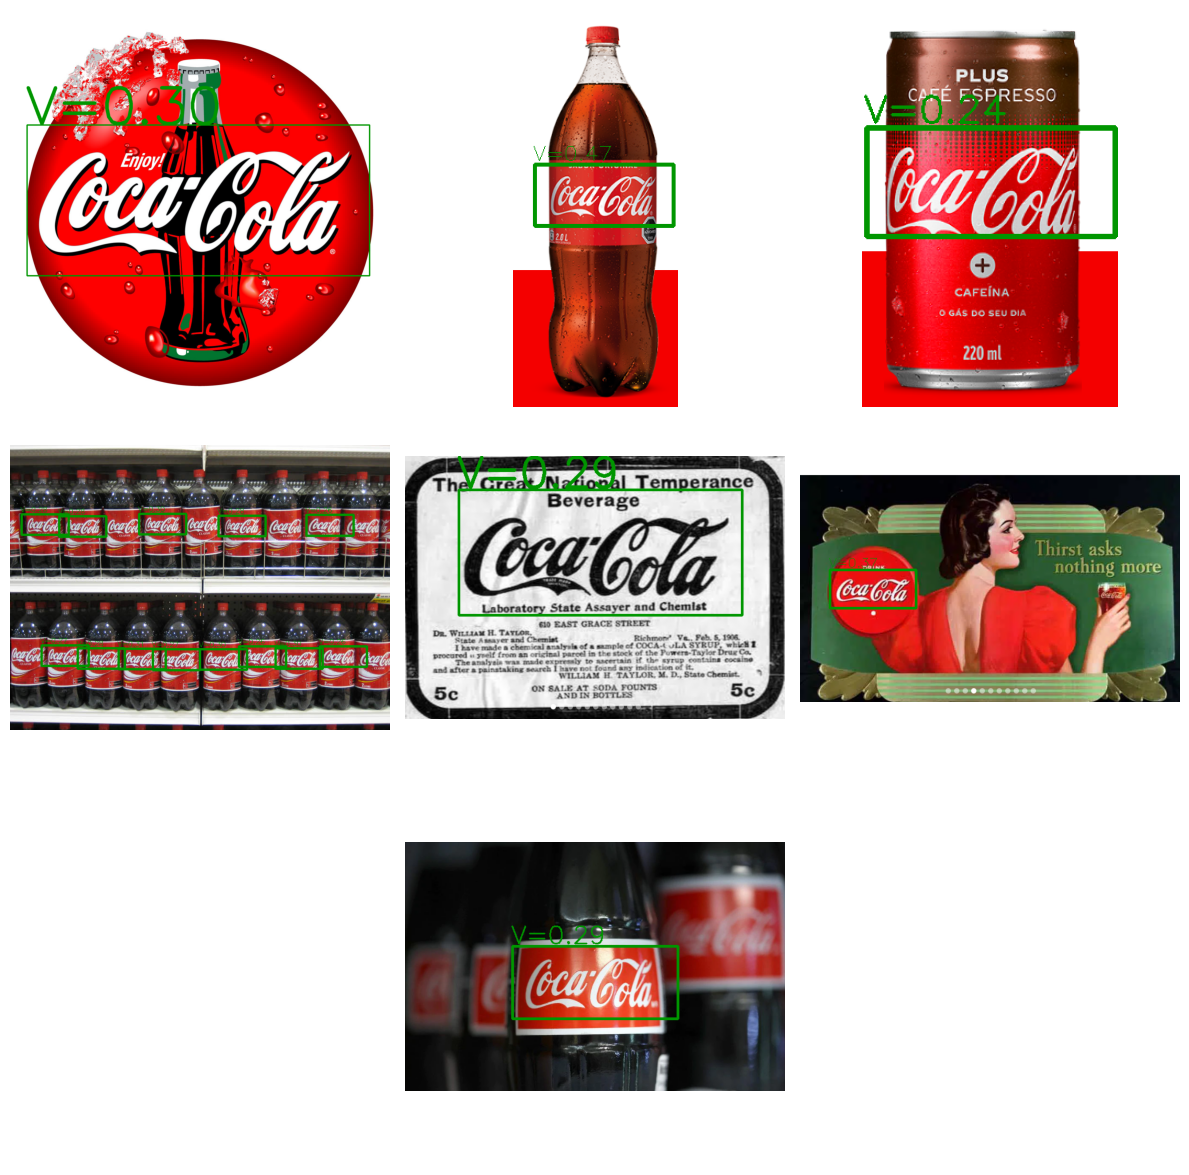

In [34]:
mostrar_imagenes([super_detector(img.copy(), template_rgb, (0.15, 2.1, 200), nms_threshold=0.7, debug=False) for img in imagenes_rgb])

<em>
Problemas detectados:

1. Inicialmente, se planteó variar el tamaño del template, para así tener una mejora en optimización, ya que el template podría estar pre-procesado en sus distintos tamaños. Esto no fue fructífero, dado que siempre se devolvía el template de menor tamaño o similar como mejor métrica. Tampoco ubicaba bien los logos.
2. Luego se probó tomar otro enfoque, hacer que las imágenes varien de tamaño. Este enfoque dió un mejor resultado, pero nuevamente tomaba la menor imágen. Esto es porque el template era más grande que la imagen.
3. Finalmente, se tomó la desición de computar las variaciones hasta que la imagen sea del tamaño del template, por lo que inicialmente se tuvo que reducir el tamaño del template para adpatarse a esta solución.
4. Si se aplicaba la solución inicial (la de variar el tamaño del template), y se comenzaba con el template de mayor tamaño, no se sabía cuando parar, por lo que no se siguió este camino.
5. El orden de aplicar Canny y resize importan. Se puede llegar a perder hasta un día por eso... Primero se hace resize y luego se aplica Canny.
</em>